In [1]:
%cd ..

/home/shpotes/Projects/safe_regions


In [2]:
from typing import Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

from safe_regions.pl_module import ResNet
from safe_regions.layers import ReLU
from safe_regions.region import RollingMeanRegion, Region

In [3]:
model = ResNet.load_from_checkpoint('weights/colab.ckpt')

In [4]:
dm = CIFAR10DataModule(
    '~/.pytorch/cifar10/',
    num_workers=8,
    batch_size=512,
)

dm.train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    cifar10_normalization(),
])

dm.val_transforms = transforms.Compose([
    transforms.ToTensor(),
    cifar10_normalization(),
])
dm.setup()

In [5]:
ood_dataset = datasets.SVHN(
    '~/.pytorch/svhn/',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        cifar10_normalization(),
    ])
)

ood_dloader = data.DataLoader(
    ood_dataset, 
    batch_size=512,
    num_workers=8,
)

Using downloaded and verified file: /home/shpotes/.pytorch/svhn/test_32x32.mat


In [6]:
class RegionMembership:
    def __init__(self, model: nn.Module):
        self.model = model.eval()
        self.state = {}
        self.hooks = []
        self._score = 0
        
    def _membership_tracker(
        self, 
        module: nn.Module, 
        parent_name: Tuple[str] = ('',)
    ):
        for idx, (layer_name, layer) in enumerate(module.named_children()):
            if isinstance(layer, ReLU):
                layer_id = (idx, *parent_name)
                h = layer.register_forward_hook(
                    self.evaluate_membership(layer_id)
                )
                self.hooks.append(h)
            elif list(layer.children()):
                self._membership_tracker(layer, (*parent_name, layer_name))
    
    @property
    def reduction_ops(self):
        return torch.mean
    
    def evaluate_membership(self, layer_id: Tuple[str]):
        state = self.state
        reduced = self.reduction_ops
        
        if not layer_id in state:
            state[layer_id] = []

        def _evaluate_membership(layer, input_tensor, _):
            (input_tensor,) = input_tensor
            membership = layer.region.evaluate_membership(
                input_tensor.detach().cpu()
            )
            state[layer_id].append(reduced(membership.float()))
            
        return _evaluate_membership
    
    def reset_state(self):
        for h in self.hooks:
            h.remove()
            
        self.state = {}
        self.hooks = []
        self._membership_tracker(self.model)

    def evaluate(self, dloader: data.DataLoader) -> Dict[Tuple[str], torch.Tensor]:
        self.reset_state()
        score = []
        
        for input_tensor, target in tqdm(dloader):
            logits = self.model(input_tensor)
            prediction = logits.max(axis=1).indices
            
            score.append((target == prediction).float().mean())

        self._score = sum(score) / len(score)
        self.state = {k: self.reduction_ops(torch.tensor(v)).item()
                      for k, v in self.state.items()}
        return self.state

    def plot(self, ax, label, offset=0, width=0.25):
        post, vals = zip(*enumerate(self.state.values()))
        post = np.array(post) + offset
        
        return ax.bar(post, vals, width=width, label=f'{label}: {self._score:.2f}')

In [7]:
_model = nn.Sequential(
    model.model,
    model.proj
)

In [8]:
tracker = RegionMembership(_model)
tracker.evaluate(dm.val_dataloader())

100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


{(2, '', '0'): 0.9462041854858398,
 (2, '', '0', 'layer1', '0'): 0.9312742352485657,
 (2, '', '0', 'layer1', '1'): 0.9352688789367676,
 (2, '', '0', 'layer2', '0'): 0.9485414624214172,
 (2, '', '0', 'layer2', '1'): 0.9318653345108032,
 (2, '', '0', 'layer3', '0'): 0.9449515342712402,
 (2, '', '0', 'layer3', '1'): 0.8348464965820312,
 (2, '', '0', 'layer4', '0'): 0.9584856033325195,
 (2, '', '0', 'layer4', '1'): 0.9497934579849243,
 (0, '', '1'): 0.9090312719345093}

In [9]:
ood_tracker = RegionMembership(model)
ood_tracker.evaluate(ood_dloader)

100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


{(2, '', 'model'): 0.9775219559669495,
 (2, '', 'model', 'layer1', '0'): 0.9497511386871338,
 (2, '', 'model', 'layer1', '1'): 0.9588596820831299,
 (2, '', 'model', 'layer2', '0'): 0.978270947933197,
 (2, '', 'model', 'layer2', '1'): 0.9670246839523315,
 (2, '', 'model', 'layer3', '0'): 0.9739352464675903,
 (2, '', 'model', 'layer3', '1'): 0.8631885051727295,
 (2, '', 'model', 'layer4', '0'): 0.9818716049194336,
 (2, '', 'model', 'layer4', '1'): 0.9829233884811401,
 (0, '', 'proj'): 0.9897645115852356}

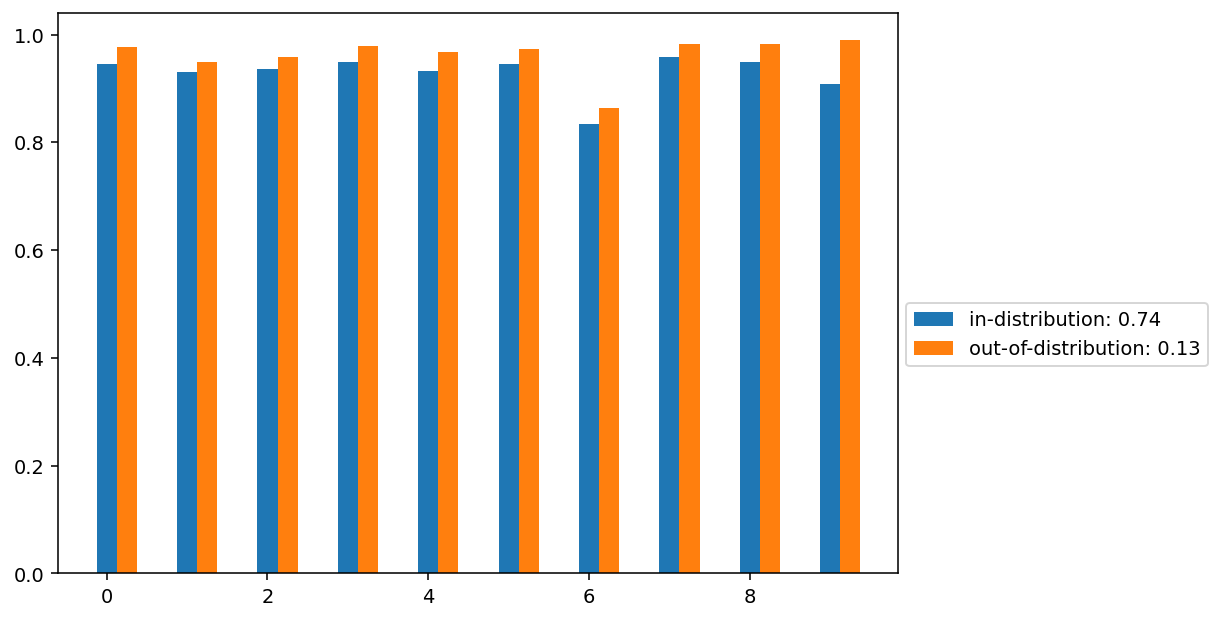

In [10]:
fig = plt.figure(dpi=140)
ax = fig.add_axes([0,0,1,1])

tracker.plot(ax, 'in-distribution')
ood_tracker.plot(ax, 'out-of-distribution', offset=0.25)

fig.legend(bbox_to_anchor=(1.38, 0.5))